In [1]:
#Para montar Gdrive en Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#Listo las carpetas que contiene el dataset
!ls 'drive/My Drive/Colab Notebooks/Dataset/covid19/'

PNEUMONIA  test  train


In [3]:
#Verifico la capacidad de GPU
!nvidia-smi

Tue Jun 30 20:23:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Librerias a importar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import copy

In [5]:
train_dataset = torchvision.datasets.ImageFolder('drive/My Drive/Colab Notebooks/Dataset/covid19/train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.544], [0.181])
                                                    
                                                ]))
test_dataset = torchvision.datasets.ImageFolder('drive/My Drive/Colab Notebooks/Dataset/covid19/test',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                    
                                                ]))
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 2908
    Root location: drive/My Drive/Colab Notebooks/Dataset/covid19/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.544], std=[0.181])
           )
Dataset ImageFolder
    Number of datapoints: 40
    Root location: drive/My Drive/Colab Notebooks/Dataset/covid19/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [6]:
batch_size_train = 8
batch_size_test = 8
learning_rate = 0.001
num_epocas = 25
step_log = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size = batch_size_train,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size_test,
                                         shuffle=True)
class_names = train_dataset.classes

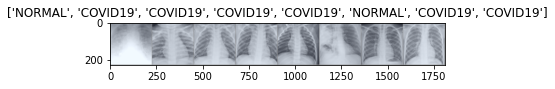

In [7]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.544])
  std = np.array([0.181])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  
inputs, classes = next(iter(test_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
torch.cuda.set_device(0) 
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print("Se entrenara con:", device)

Se entrenara con: cuda


In [9]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 256, kernel_size=3)    
    self.bn1 = nn.BatchNorm2d(256)    
    self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
    #512 de la capa previa, 26 tamaño de la imagen
    self.fc1 = nn.Linear(512*26*26,50)  #Una capa full conected, 50 es el numero de neuronas q quiero 
    self.fc2 = nn.Linear(50,2) #son  clases
    
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)  #2 el tamaño de la ventana de pooling
    #x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.bn1(self.conv2(x))), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    #x = F.relu(self.conv3(x)
    #x = x.view(-1,30*5*5) #al valor de x le hago un, -1 desdoblo las dimensiones a un size de 320
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x)
  
  def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

network = Network()

In [10]:
network = network.to(device)

In [11]:
#Modelo
def train_model(model, criterio, optimizer, scheduler, num_epochs):  
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_train = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 25)
    
        #Train model
        #During an epoch, we need to update the LR using the ‘.step()’ method of the scheduler object
        scheduler.step()
        #Tells your model that you are training the model
        model.train()
    
        running_loss = 0.0
        running_corrects = 0.0
    
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            #In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
            #because PyTorch accumulates the gradients on subsequent backward passes.
            optimizer.zero_grad()
        
            outputs = model(inputs)
        
            #Si utilizo softmax, puedo usar exp
            #We are doing it here just to make our predictions look like probabilities 
            #which sometimes helps in debugging. You are free to remove torch.exp 
            #call in the code if you want. torch.max returns a tuple containing the maximum value 
            #and the index of the maximum value within the tensor. Since the index in our case 
            #represents the classified category itself, we will only take that ignoring 
            #the actual probability.
            #_, preds = torch.max(torch.exp(outputs), 1)
        
            #pytorch.max
            #Returns the maximum value of all elements in the input tensor.
            _, preds = torch.max(outputs, 1)
        
            #you should use labels, because u need to get loss by comparing ground truth 
            #and predicting label, the predict is outputs, and the ground truth is labels
            loss = criterion(outputs, labels)
        
            #loss.backward() computes dloss/dx for every parameter x which has 
            #requires_grad=True. These are accumulated into x.grad for every parameter x        
            loss.backward()
        
            #optimizer.step updates the value of x using the gradient x.grad
            optimizer.step()
        
            #the loss returned is an average over all examples in a batch, given this, 
            #you could simply divide the running loss by the number of batches, 
            #however since the final batch is often not the same size with others, 
            #your results would be inaccurate, hence, the solution is to reverse the average 
            #by multiplying the loss in a batch by the total number of images in the batch, 
            #this gives unaveraged sum of losses over all examples, when you divide the running loss 
            #by the total number of images ,you get accurate loss metrics.
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss_train = running_loss /len(train_dataset)
        epoch_acc_train = running_corrects.double() / len(train_dataset)
    
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))
        if epoch_acc_train > best_acc_train:
              best_acc_train = epoch_acc_train

              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(best_model_wts, 'resnetxt.pth')
   
   #validation--- se elimino
              
    time_elapsed = time.time() - since
    print("####################################################")
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best train accucary: {:.4f}'.format(best_acc_train))
    #print('Best val accucary: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def test_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
            
    epoch_loss = running_loss /len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)
        
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return test_model

In [13]:
def visualize_model(model, num_images):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode = was_training)

In [14]:
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model_propio = train_model(network, criterion, optimizer, scheduler, num_epochs=100)

Epoch 0/99
-------------------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Loss: 0.5814 Acc: 0.7063
Epoch 1/99
-------------------------
Train Loss: 0.4663 Acc: 0.8030
Epoch 2/99
-------------------------
Train Loss: 0.4205 Acc: 0.8239
Epoch 3/99
-------------------------
Train Loss: 0.3768 Acc: 0.8477
Epoch 4/99
-------------------------
Train Loss: 0.3487 Acc: 0.8618
Epoch 5/99
-------------------------
Train Loss: 0.3532 Acc: 0.8563
Epoch 6/99
-------------------------
Train Loss: 0.3280 Acc: 0.8680
Epoch 7/99
-------------------------
Train Loss: 0.3280 Acc: 0.8759
Epoch 8/99
-------------------------
Train Loss: 0.3434 Acc: 0.8628
Epoch 9/99
-------------------------
Train Loss: 0.3326 Acc: 0.8669
Epoch 10/99
-------------------------
Train Loss: 0.3379 Acc: 0.8659
Epoch 11/99
-------------------------
Train Loss: 0.3120 Acc: 0.8796
Epoch 12/99
-------------------------
Train Loss: 0.3281 Acc: 0.8728
Epoch 13/99
-------------------------
Train Loss: 0.3207 Acc: 0.8762
Epoch 14/99
-------------------------
Train Loss: 0.3286 Acc: 0.8714
Epoch 15/99


In [15]:
model_propio_test = test_model(model_propio)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 1.4970 Acc: 0.3500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


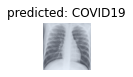

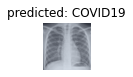

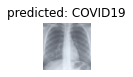

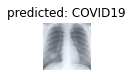

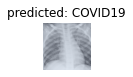

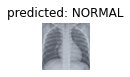

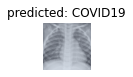

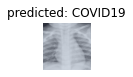

In [16]:
visualize_model(model=model_propio, num_images = 8)